Based on Semtorch (https://pypi.org/project/SemTorch/)

In [5]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
import os
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
from fastai.callback.fp16 import *
from semtorch import get_segmentation_learner

from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)


In [2]:
path = Path("./data/train")

In [3]:
### Function to make correspondace between images and masks
def label_func(fn): return path/"masks"/f"{fn.stem}{fn.suffix}"

In [4]:
def MaskBlockCustom(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), 
                          batch_tfms=IntToFloatTensor(div_mask=255))

In [6]:
# Class for data augmentation
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [7]:
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [8]:
def get_dls(bs, size):
    "Return dataloader"

    nuclie_seg = DataBlock(blocks=(ImageBlock, MaskBlockCustom()),
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                       item_tfms=[Resize((size,size)),transformPipeline],
                       batch_tfms=Normalize.from_stats(*imagenet_stats),
                    )
    return nuclie_seg.dataloaders(path/"images", path=path, bs=bs)

In [9]:
dls = get_dls(8,156)


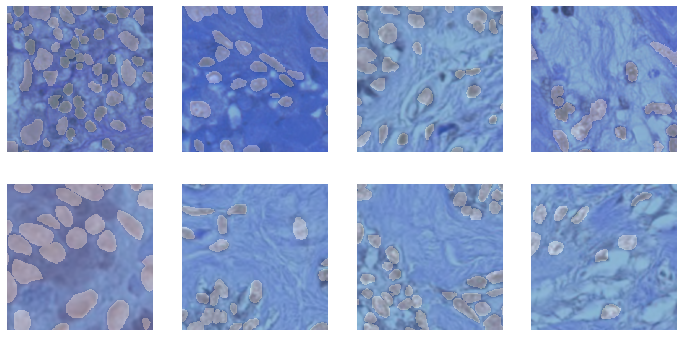

In [10]:
dls.show_batch(max_n=10)


In [14]:
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None

### Training

In [44]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=4

#### Using Smaller Size image for faster training

In [35]:
dls = get_dls(4,156)

In [36]:
fname="deeplabv3-segmentron-resnet34-before-resizing-WD-2-best"
callbacksFitBeforeResizing = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]

#### Deeplabv3 architecture with mobilenetv2 backbone

In [37]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="mobilenet_v2", 
                                 metrics= Dice(),wd=1e-2).to_fp16()

In [38]:
learn.freeze() # Freezing the backbone

Recorder

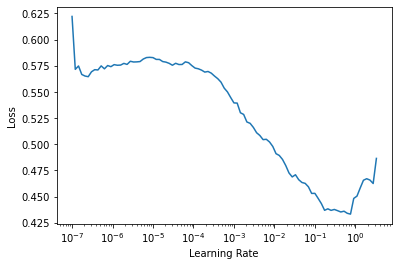

In [39]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,time
0,0.190777,0.172497,0.759914,00:47
1,0.173819,0.163179,0.779189,00:47
2,0.173456,0.171768,0.756816,00:47
3,0.170264,0.154123,0.799820,00:47
4,0.157537,0.157383,0.784799,00:46
5,0.160400,0.161569,0.766006,00:47


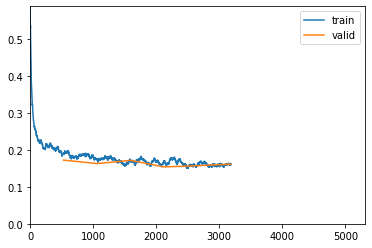

Better model found at epoch 0 with dice value: 0.7599139757892167.
Better model found at epoch 1 with dice value: 0.7791893598054569.
Better model found at epoch 3 with dice value: 0.7998202198795146.
No improvement since epoch 3: early stopping


In [40]:
learn.fit_flat_cos(10,3e-3,cbs=callbacksFitBeforeResizing)

#### Load best weight

In [47]:
learn.load("deeplabv3-segmentron-resnet34-before-resizing-WD-2-best")

/home/newrun2/Projects/Marwen/venv/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


### Progressive Oversizing

In [48]:
learn.dls = get_dls(4, 256)


Recorder

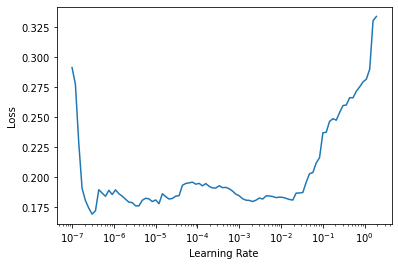

In [49]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [50]:
fname="deeplabv3-segmentron-mobilenet-after-resizing-WD-2-best"
callbacksFitAfterResizing = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]

epoch,train_loss,valid_loss,dice,time
0,0.159311,0.156657,0.807212,00:51
1,0.161755,0.152557,0.810716,00:50
2,0.151135,0.154897,0.812274,00:51
3,0.154001,0.156543,0.803698,00:50
4,0.151835,0.155634,0.808604,00:51
5,0.146390,0.157192,0.802642,00:50


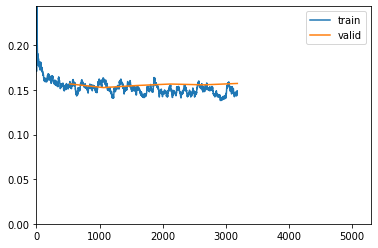

Better model found at epoch 0 with dice value: 0.8072121404112172.
Better model found at epoch 1 with dice value: 0.810716068105943.
Better model found at epoch 2 with dice value: 0.8122739513795841.
No improvement since epoch 1: early stopping


In [51]:
learn.fit_flat_cos(10,slice(5e-6,5e-4),cbs=callbacksFitAfterResizing)

In [53]:
learn.load(fname)
learn.validate()

(#2) [0.15489666163921356,0.8122739513795841]

#### Unfreezing

Recorder

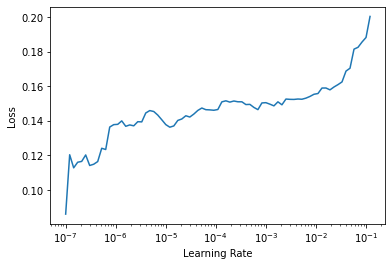

In [54]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [56]:
fname="deeplabv3-segmentron-mobilenet-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]


epoch,train_loss,valid_loss,dice,time
0,0.151422,0.155048,0.806905,00:51
1,0.143183,0.154203,0.808316,00:51
2,0.150722,0.153130,0.807748,00:51
3,0.148891,0.152769,0.812556,00:52
4,0.144550,0.151140,0.814140,00:50
5,0.150313,0.151840,0.815252,00:51
6,0.152213,0.151421,0.812753,00:51
7,0.149334,0.151188,0.813770,00:51
8,0.141800,0.150105,0.814666,00:51
9,0.139619,0.149458,0.815058,00:51


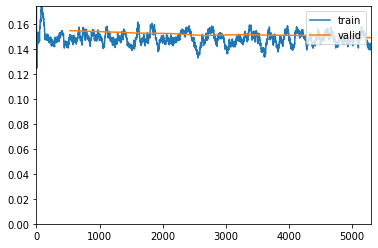

Better model found at epoch 0 with valid_loss value: 0.15504829585552216.
Better model found at epoch 1 with valid_loss value: 0.15420348942279816.
Better model found at epoch 2 with valid_loss value: 0.15313005447387695.
Better model found at epoch 3 with valid_loss value: 0.15276868641376495.
Better model found at epoch 4 with valid_loss value: 0.15114031732082367.
Better model found at epoch 8 with valid_loss value: 0.15010467171669006.
Better model found at epoch 9 with valid_loss value: 0.14945779740810394.


In [57]:
learn.fit_flat_cos(10,slice(5e-7,5e-6),cbs=callbacksFitAfterUnfreeze)

### Saving Model

In [58]:
learn.export(fname="./models/mobilenet_final.pkl")

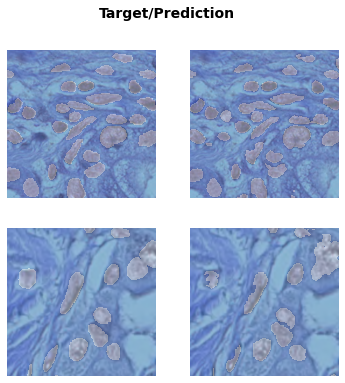

In [60]:
learn.show_results()